1. Import libraries.

In [200]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from skfeature.function.similarity_based import fisher_score

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

2. Define functions.

In [201]:
def get_top_features(df, X, y, target_col="Y", top_n=3, random_state=1):
    # 1. Correlation with the target variable
    # plt.figure(figsize=(12,8))
    corr = df.corr()
    # sns.heatmap(corr, annot=True)
    # plt.show();
    
    scores_dicts = {}
    top_n_dicts = {}
    
    corr_dict = {k: v for k, v in sorted(dict(corr[target_col].drop(target_col)).items(), key=lambda item: item[1], reverse=True)}
    scores_dicts["correlation_coefficient"] = corr_dict
    top_n_dicts["correlation_coefficient"] = list(corr_dict.keys())[:top_n]
    
    # 2. Information gain
    # Information gain calculates the reduction in entropy from the transformation of a dataset.
    # It can be used for feature selection by evaluating the Information gain of each variable 
    # in the context of the target variable.
    info_gain_scores = mutual_info_classif(X, y)
    info_gain = {col: info_gain_score for info_gain_score, col in zip(info_gain_scores, X.columns)}
    info_gain_sorted = {k: v for k, v in sorted(info_gain.items(), key=lambda item: item[1], reverse=True)}
    scores_dicts["information_gain"] = info_gain_sorted
    top_n_dicts["information_gain"] = list(info_gain_sorted.keys())[:top_n]
    
    # 3. Fisher's score
    # Fisher score is one of the most widely used supervised feature selection methods.
    # The algorithm which we will use returns the ranks of the variables
    # based on the fisher's score in descending order.
    fisher_score_ranks = fisher_score.fisher_score(X.to_numpy(), y) +1
    fisher_ranks = {col: fisher_score_rank for fisher_score_rank, col in zip(fisher_score_ranks, X.columns)}
    fisher_ranks_sorted = {k: v for k, v in sorted(fisher_ranks.items(), key=lambda item: item[1])}
    scores_dicts["fisher_ranks"] = fisher_ranks_sorted
    top_n_dicts["fisher_ranks"] = list(fisher_ranks_sorted.keys())[:top_n]
    
    # 4. Use a simple random forest model for evaluating feature importances, etc.
    random_forest = RandomForestClassifier(max_depth=2, random_state=random_state)
    random_forest.fit(X, y)
    feature_importances = random_forest.feature_importances_
    feature_importance = {col: feature_importance for feature_importance, col in zip(feature_importances, X.columns)}
    feature_importance_sorted = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}
    scores_dicts["feature_importance"] = feature_importance_sorted
    top_n_dicts["feature_importance"] = list(feature_importance_sorted.keys())[:top_n]
    
    scores_df = pd.DataFrame(scores_dicts)
    top_n_df = pd.DataFrame(top_n_dicts)
    
    return scores_df, top_n_df


def randomized_search(model, X_train, y_train, params, scoring="accuracy", random_state=1, test_size=0.1, n_splits=1, n_iter=100):
    sss = StratifiedShuffleSplit(random_state=random_state, test_size=test_size, n_splits=n_splits) # n_splits=10 by default
    best_searched = RandomizedSearchCV(estimator=model, param_distributions=params, cv=sss,
                                        scoring=scoring, random_state=random_state, n_iter=n_iter) # n_iter=10 by default
    best_searched.fit(X_train, y_train)
    return best_searched


def get_mean_accuracy_scores(X, y, columns, n=100, random_state=1, test_size=0.1):
    base_model=RandomForestClassifier(random_state)
    accuracy_scores = []
    for i in range(n):
        _X = X[columns]
        X_train, X_test, y_train, y_test = \
            train_test_split(_X, y, test_size=test_size, random_state=random_state)
            
        base_model.fit(X_train, y_train)
        y_pred = base_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

    print(f"Mean accuracy score with columns {columns}: {round(np.mean(accuracy_scores), 2)}")

In [202]:
random_state = 1
test_size = 0.2

3. Load data and perform EDA to understand the data.

In [203]:
survey_df = pd.read_csv("./data/ACME-HappinessSurvey2020.csv")
survey_df.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [204]:
# Data Description:

# Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers
# X1 = my order was delivered on time
# X2 = contents of my order was as I expected
# X3 = I ordered everything I wanted to order
# X4 = I paid a good price for my order
# X5 = I am satisfied with my courier
# X6 = the app makes ordering easy for me

In [205]:
survey_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


In [206]:
survey_df.describe()

,Y,X1,X2,X3,X4,X5,X6
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


5. Define X and y.

In [207]:
X = survey_df.drop("Y", axis=1)
y = survey_df["Y"]

In [208]:
y.value_counts()

1    69
0    57
Name: Y, dtype: int64

In [209]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_balanced, y_balanced = oversample.fit_resample(X, y)
y_balanced.value_counts()

0    69
1    69
Name: Y, dtype: int64

6. Analyze feature importance - i.e. feature selection

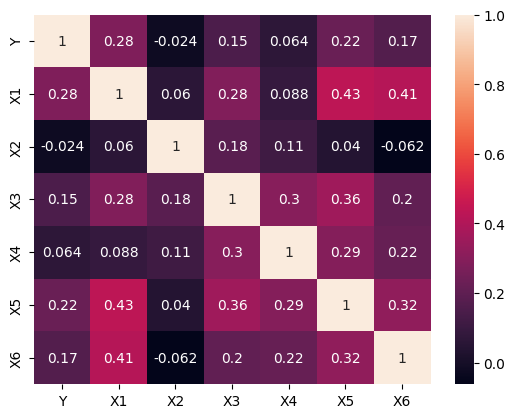

In [210]:
corr = survey_df.corr()
sns.heatmap(corr, annot=True)
plt.show();

In [211]:
scores_df, top_n_df = get_top_features(survey_df, X_balanced, y_balanced, top_n=3, random_state=random_state)

In [212]:
scores_df

,correlation_coefficient,information_gain,fisher_ranks,feature_importance
X1,0.280160,0.018886,6,0.286200
X5,0.224522,0.007955,3,0.194055
X6,0.167669,0.053319,5,0.201701
X3,0.150838,0.000000,1,0.123770
X4,0.064415,0.000000,4,0.113283
X2,-0.024274,0.010865,2,0.080990


In [213]:
top_n_df

,correlation_coefficient,information_gain,fisher_ranks,feature_importance
0,X1,X6,X3,X1
1,X5,X1,X2,X6
2,X6,X2,X5,X5


Run the function multiple times to take into account randomness.

In [214]:
top_n_dfs = pd.DataFrame()
for i in range(100):
    _, top_n_df = get_top_features(survey_df, X_balanced, y_balanced, top_n=3, random_state=1)
    top_n_dfs = pd.concat([top_n_dfs, top_n_df])

In [215]:
top_n_occurrence = defaultdict(int)
for i in range(len(top_n_dfs.columns)):
    col_dict = top_n_dfs.iloc[:,i].value_counts().to_dict()
    for k, v in col_dict.items():
        top_n_occurrence[k] += v

top_n_occurrence = dict(sorted(top_n_occurrence.items(), key=lambda item: item[1]))
top_n_occurrence

{'X4': 31, 'X3': 137, 'X2': 151, 'X6': 247, 'X1': 288, 'X5': 346}

In [216]:
for col in X.columns:
    columns = list(X.columns)
    columns.remove(col)
    get_mean_accuracy_scores(X_balanced, y_balanced, columns)

Mean accuracy score with columns ['X2', 'X3', 'X4', 'X5', 'X6']: 0.6
Mean accuracy score with columns ['X1', 'X3', 'X4', 'X5', 'X6']: 0.65
Mean accuracy score with columns ['X1', 'X2', 'X4', 'X5', 'X6']: 0.7
Mean accuracy score with columns ['X1', 'X2', 'X3', 'X5', 'X6']: 0.59
Mean accuracy score with columns ['X1', 'X2', 'X3', 'X4', 'X6']: 0.59
Mean accuracy score with columns ['X1', 'X2', 'X3', 'X4', 'X5']: 0.62


In [217]:
for col in X.columns:
    get_mean_accuracy_scores(X_balanced, y_balanced, [col])

Mean accuracy score with columns ['X1']: 0.78
Mean accuracy score with columns ['X2']: 0.47
Mean accuracy score with columns ['X3']: 0.35
Mean accuracy score with columns ['X4']: 0.44
Mean accuracy score with columns ['X5']: 0.46
Mean accuracy score with columns ['X6']: 0.59


Based on the different evaluation metrics above, below would be the importance of the features:
- High: X1, X5, X6
- Low: X2, X3, X4

In [218]:
for columns in [["X1", "X5"],
                ["X1", "X5", "X6"],
                ["X1", "X5", "X6", "X2"],
                ["X1", "X5", "X6", "X3"],
                ["X1", "X5", "X6", "X4"],]:
    get_mean_accuracy_scores(X_balanced, y_balanced, columns)

Mean accuracy score with columns ['X1', 'X5']: 0.69
Mean accuracy score with columns ['X1', 'X5', 'X6']: 0.7
Mean accuracy score with columns ['X1', 'X5', 'X6', 'X2']: 0.68
Mean accuracy score with columns ['X1', 'X5', 'X6', 'X3']: 0.64
Mean accuracy score with columns ['X1', 'X5', 'X6', 'X4']: 0.65


Take "X1", "X5", "X6" as features and split into train, validate, and test sets.

In [229]:
df_balanced = pd.concat([X_balanced, y_balanced], axis=1)
train_df, validate_df, test_df = np.split(
                                    df_balanced[["X1", "X5", "X6", "Y"]].sample(frac=1), # shuffle the entire data set. 
                                    [int(.8*len(survey_df)), # Take 10% of data as validate set.
                                    int(.9*len(survey_df))] # Take 10% of data as test set.
                                )                           # The rest (80%) will be train set.

In [230]:
train_X = train_df.drop("Y", axis=1)
train_y = train_df["Y"]
validate_X = validate_df.drop("Y", axis=1)
validate_y = validate_df["Y"]
test_X = test_df.drop("Y", axis=1)
test_y = test_df["Y"]

In [231]:
# X_train, X_test, y_train, y_test = \
#     train_test_split(X_balanced[["X1", "X5", "X6"]], y_balanced, test_size=test_size, random_state=random_state)

7. Try different binary classifiers to select the best performing model - i.e. model selection.

In [235]:
rogistic_regression = LogisticRegression()
random_forest = RandomForestClassifier(random_state=random_state)
ada_boost = AdaBoostClassifier(random_state=random_state)
gaussian = GaussianNB()
bernoulli = BernoulliNB()
logistic_regression_cv = LogisticRegressionCV()
linear_discriminant = LinearDiscriminantAnalysis()
quadratic_discriminant = QuadraticDiscriminantAnalysis()
gradient_boosting = GradientBoostingClassifier(random_state=random_state)
extra_trees = ExtraTreesClassifier(random_state=random_state)
decision_tree = DecisionTreeClassifier(random_state=random_state)
sgd = SGDClassifier(random_state=random_state)
mlp = MLPClassifier(random_state=random_state)
k_neighbors = KNeighborsClassifier()

models = [rogistic_regression, random_forest, ada_boost, gaussian, bernoulli,
          logistic_regression_cv, linear_discriminant, quadratic_discriminant, gradient_boosting,
          extra_trees, decision_tree, sgd, mlp, k_neighbors]

best_models = []
best_score = 0

for model in models:
    model.fit(train_X, train_y)
    y_pred = model.predict(validate_X)

    accuracy = accuracy_score(validate_y, y_pred)
    if accuracy >= best_score:
        best_score = accuracy
        best_models.append(model)
    print(model, accuracy)

print()
for best_model in best_models:
    print(f"Best model: {type(best_model).__name__}, Best score: {best_score}")

LogisticRegression() 0.6923076923076923
RandomForestClassifier(random_state=1) 0.6923076923076923
AdaBoostClassifier(random_state=1) 0.5384615384615384
GaussianNB() 0.6923076923076923
BernoulliNB() 0.38461538461538464
LogisticRegressionCV() 0.6923076923076923
LinearDiscriminantAnalysis() 0.6923076923076923
QuadraticDiscriminantAnalysis() 0.7692307692307693
GradientBoostingClassifier(random_state=1) 0.38461538461538464
ExtraTreesClassifier(random_state=1) 0.46153846153846156
DecisionTreeClassifier(random_state=1) 0.46153846153846156
SGDClassifier(random_state=1) 0.6923076923076923
MLPClassifier(random_state=1) 0.6153846153846154
KNeighborsClassifier() 0.38461538461538464

Best model: LogisticRegression, Best score: 0.7692307692307693
Best model: RandomForestClassifier, Best score: 0.7692307692307693
Best model: GaussianNB, Best score: 0.7692307692307693
Best model: LogisticRegressionCV, Best score: 0.7692307692307693
Best model: LinearDiscriminantAnalysis, Best score: 0.7692307692307693

Multiple classifiers without any hyperparameter tuning already exceeded the target accuracy score of 73%.

8. Try different hyperparameters for RandomForestClassifier - i.e. hyperparameter tuning.

In [236]:
# params = {
#     "n_neighbors": np.arange(1, 10, 1),
#     "weights": ["uniform", "distance"],
#     "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
#     "leaf_size": np.arange(5, 50, 5),
#     "p": [1, 2]
# }
params = {
    "n_estimators": np.arange(10,200,10),
    # "criterion": ["gini", "entropy", "log_loss"],
    # "min_weight_fraction_leaf": np.arange(0, 1, 0.01),
    "max_features": ["sqrt", "log2", None],
    "warm_start": [True, False],
    "class_weight": ["balanced", "balanced_subsample", None],
    "ccp_alpha": np.arange(0, 1, 0.01)
}
best_searched = randomized_search(random_forest, train_X, train_y, params)
best_searched.best_estimator_, best_searched.best_score_, best_searched.best_params_

(RandomForestClassifier(ccp_alpha=0.1, class_weight='balanced_subsample',
                        max_features='log2', n_estimators=180, random_state=1,
                        warm_start=True),
 0.8,
 {'warm_start': True,
  'n_estimators': 180,
  'max_features': 'log2',
  'class_weight': 'balanced_subsample',
  'ccp_alpha': 0.1})

In [237]:
best_model_with_best_params = best_searched.best_estimator_
y_pred = best_model_with_best_params.predict(test_X)
accuracy = accuracy_score(test_y, y_pred)
accuracy

0.6

Hyperparameter tuning didn't help, probably because the complexity and volume of the data were very low.

In [ ]:
- hyperparameter tuning using validate set or train set?
- try hyperparameter tuning for logistic regression (since the data is small and simple, complex models might not perform very well or could overfit.)
- try using penalty for random forest for minority class.
# https://www.kaggle.com/code/rafjaa/dealing-with-very-small-datasets